In [1]:
import cv2
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


In [ ]:

image_bgr = cv2.imread('../../data/imgs/0618.png')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask = cv2.imread('../../data/imgs/mask0618.png', cv2.IMREAD_GRAYSCALE)
Y = mask.flatten()
Y = np.where(Y > 128, 1, 0)  # 1 表示道路，0 表示非道路

block_size = 5
height, width, _ = image_rgb.shape

In [ ]:
features, labels = [], []
for i in range(0, height - block_size + 1, block_size):
    for j in range(0, width - block_size + 1, block_size):
        block = image_rgb[i:i + block_size, j:j + block_size]
        
        mean_rgb = np.mean(block, axis=(0, 1))
        var_rgb = np.var(block, axis=(0, 1))
        block_hsv = cv2.cvtColor(block, cv2.COLOR_RGB2HSV)
        mean_hsv = np.mean(block_hsv, axis=(0, 1))
        var_hsv = np.var(block_hsv, axis=(0, 1))
        block_lab = cv2.cvtColor(block, cv2.COLOR_RGB2LAB)
        mean_lab = np.mean(block_lab, axis=(0, 1))
        var_lab = np.var(block_lab, axis=(0, 1))

        feature_vector = np.concatenate([mean_rgb, var_rgb, mean_hsv, var_hsv, mean_lab, var_lab])
        block_mask = mask[i:i + block_size, j:j + block_size].flatten()
        label = 1 if np.sum(block_mask) > (block_size * block_size / 2) else 0
        
        features.append(feature_vector)
        labels.append(label)

X = np.array(features)
y = np.array(labels)

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
gnb = GaussianNB()
gnb.fit(X, y)

GaussianNB()

In [ ]:
def sequential_fusion(image, model, scaler, block_size=5, window_size=3):
    height, width, _ = image.shape
    segmented_image = np.zeros((height, width), dtype=np.uint8)
    
    for i in range(height):
        for j in range(width):
            cumulative_posterior = 0
            pixel_count = 0
            
            # 动态滑动窗口范围
            for offset_i in range(-window_size // 2, window_size // 2 + 1):
                for offset_j in range(-window_size // 2, window_size // 2 + 1):
                    ni, nj = i + offset_i, j + offset_j
                    if 0 <= ni < height and 0 <= nj < width:
                        top = max(0, ni - block_size // 2)
                        bottom = min(height, ni + block_size // 2 + 1)
                        left = max(0, nj - block_size // 2)
                        right = min(width, nj + block_size // 2 + 1)

                        # 提取区域特征
                        block = image[top:bottom, left:right]
                        mean_rgb = np.mean(block, axis=(0, 1))
                        var_rgb = np.var(block, axis=(0, 1))
                        block_hsv = cv2.cvtColor(block, cv2.COLOR_RGB2HSV)
                        mean_hsv = np.mean(block_hsv, axis=(0, 1))
                        var_hsv = np.var(block_hsv, axis=(0, 1))
                        block_lab = cv2.cvtColor(block, cv2.COLOR_RGB2LAB)
                        mean_lab = np.mean(block_lab, axis=(0, 1))
                        var_lab = np.var(block_lab, axis=(0, 1))

                        # 组合特征并标准化
                        feature_vector = np.concatenate([mean_rgb, var_rgb, mean_hsv, var_hsv, mean_lab, var_lab])
                        feature_vector = scaler.transform([feature_vector])

                        # 获取当前块的后验概率
                        posterior_prob = model.predict_proba(feature_vector)[0][1]
                        
                        # 累积后验概率并计数
                        cumulative_posterior += posterior_prob
                        pixel_count += 1

            # 计算平均后验概率，作为融合后的结果
            avg_posterior = cumulative_posterior / pixel_count
            segmented_image[i, j] = int(avg_posterior * 255)

    return segmented_image

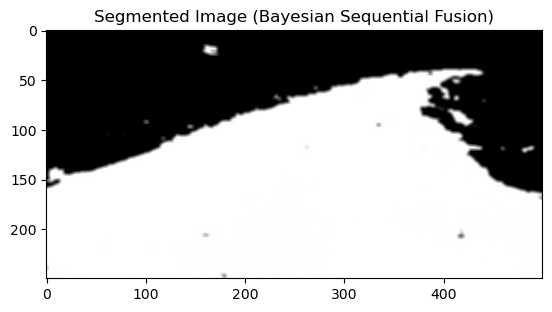

In [6]:
# 测试图像分割
segmented_image = sequential_fusion(image_rgb, gnb, scaler)

# 显示结果图像
plt.imshow(segmented_image, cmap='gray')
plt.title("Segmented Image (Bayesian Sequential Fusion)")
plt.show()

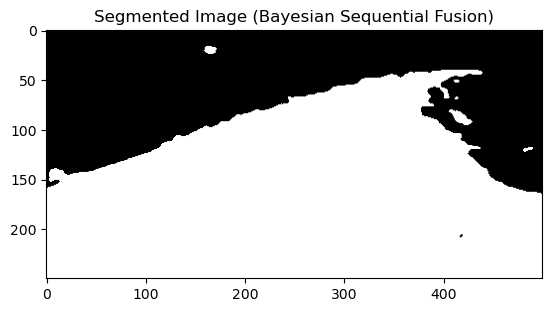

In [ ]:
segmented_image = np.where(segmented_image > 128, 255, 0)
# 显示结果图像
plt.imshow(segmented_image, cmap='gray')
plt.title("Segmented Image (Bayesian Sequential Fusion)")
plt.show()